# Dogs vs Cats

https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition

In [1]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import vgg16

print(tf.__version__)
print(tf.executing_eagerly())

2.8.0
True


In [2]:
# Подключение к Kaggle через Kaggle API реализую с помощью API Token:
# https://www.kaggle.com/general/74235
# Easiest way to download kaggle data in Google Colab

! pip install -q kaggle

In [ ]:
# импортирую свой Kaggle API Token
from google.colab import files

# Choose the kaggle.json file  (Kaggle API Token)
files.upload()

In [4]:
#  Make directory named kaggle and copy kaggle.json file there.
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

In [5]:
# Change the permissions of the file.
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
# That's all ! You can check if everything's okay by running this command
# (список датасетов с Kaggle)
! kaggle datasets list

ref                                                                            title                                             size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------------------------  -----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
datasets/muratkokludataset/date-fruit-datasets                                 Date Fruit Datasets                              408KB  2022-04-03 09:25:39           7046        936  0.9375           
datasets/mdmahmudulhasansuzan/students-adaptability-level-in-online-education  Students Adaptability Level in Online Education    6KB  2022-04-16 04:46:28           4569        114  1.0              
datasets/muratkokludataset/rice-image-dataset                                  Rice Image Dataset                               219MB  2022-04-03 02:12:00           1329        762  0.875            


In [7]:
# Download required dataset from Kaggle
!kaggle competitions download -c dogs-vs-cats-redux-kernels-edition

 98% 801M/814M [00:06<00:00, 182MB/s]
100% 814M/814M [00:06<00:00, 139MB/s]


In [8]:
! unzip dogs-vs-cats-redux-kernels-edition.zip

Archive:  dogs-vs-cats-redux-kernels-edition.zip
  inflating: sample_submission.csv   
  inflating: test.zip                
  inflating: train.zip               


In [ ]:
! unzip test.zip

In [ ]:
! unzip train.zip

## Функции загрузки данных

In [11]:
import os
print(os.listdir("../content"))

['.config', 'sample_submission.csv', 'test.zip', 'test', 'train.zip', 'kaggle.json', 'dogs-vs-cats-redux-kernels-edition.zip', 'train', 'sample_data']


In [12]:
from random import shuffle
from glob import glob

IMG_SIZE = (224, 224)  # размер входного изображения сети

train_files = glob('../content/train/*.jpg')
test_files = glob('../content/test/*.jpg')

# загружаем входное изображение и предобрабатываем
def load_image(path, target_size=IMG_SIZE):
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, target_size)
    return vgg16.preprocess_input(img)  # предобработка для VGG16

# функция-генератор загрузки обучающих данных с диска
def fit_generator(files, batch_size=32):
    batch_size = min(batch_size, len(files))
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1. if os.path.basename(path).startswith('dog') else 0.
                          for path in files[i:j]])
            yield (x, y)

# функция-генератор загрузки тестовых изображений с диска
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])

## Визуализируем примеры для обучения

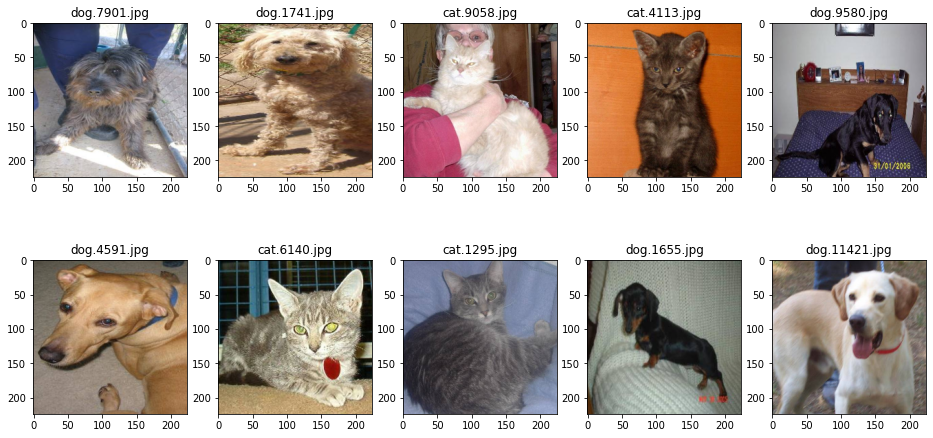

In [13]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(16, 8))
for i, path in enumerate(train_files[:10], 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%s' % path.split('/')[-1])
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    plt.imshow(img)

## Загружаем предобученную модель

In [33]:
# base_model - объект класса keras.models.Model (Functional Model)
base_model = vgg16.VGG16(weights='imagenet',
                         include_top=False,
                         input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

In [34]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## Добавляем полносвязный слой

In [35]:
# фиксируем все веса предобученной сети
for layer in base_model.layers:
    layer.trainable = False

x = base_model.layers[-5].output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1,  # один выход (бинарная классификация)
                          activation='sigmoid',  # функция активации  
                          kernel_regularizer=tf.keras.regularizers.l1(1e-4))(x)

model = tf.keras.Model(inputs=base_model.input, outputs=x, name='dogs_vs_cats')

## Выводим архитектуру модели

In [36]:
model.summary()

Model: "dogs_vs_cats"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)      

## Компилируем модель и запускаем обучение

In [37]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy',  # функция потерь binary_crossentropy (log loss
              metrics='accuracy')

In [40]:
val_samples = 5000  # число изображений в валидационной выборке

shuffle(train_files)  # перемешиваем обучающую выборку
validation_data = next(fit_generator(train_files[:val_samples], val_samples))
train_data = fit_generator(train_files[val_samples:])  # данные читаем функцией-генератором

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'cats-dogs-vgg16.hdf5',
    monitor='loss',
    verbose=1,  
    save_best_only=True, 
    save_weights_only=False,
    mode='auto',
    save_freq=10)

# запускаем процесс обучения
model.fit(train_data,
          steps_per_epoch=10,  # число вызовов генератора за эпоху
          epochs=20,  # число эпох обучения
          validation_data=validation_data,
          callbacks=[checkpoint])

Epoch 1/20
 9/10 [==========================>...] - ETA: 0s - loss: 15.1900 - accuracy: 0.9757
Epoch 1: loss improved from inf to 13.68598, saving model to cats-dogs-vgg16.hdf5
10/10 [==============================] - 27s 3s/step - loss: 13.6860 - accuracy: 0.9781 - val_loss: 19.5556 - val_accuracy: 0.9744
Epoch 2/20
 9/10 [==========================>...] - ETA: 0s - loss: 21.6206 - accuracy: 0.9757
Epoch 2: loss did not improve from 13.68598
10/10 [==============================] - 25s 3s/step - loss: 19.4735 - accuracy: 0.9781 - val_loss: 25.4284 - val_accuracy: 0.9672
Epoch 3/20
 9/10 [==========================>...] - ETA: 0s - loss: 25.3965 - accuracy: 0.9688
Epoch 3: loss did not improve from 13.68598
10/10 [==============================] - 24s 3s/step - loss: 34.3312 - accuracy: 0.9625 - val_loss: 38.2908 - val_accuracy: 0.9592
Epoch 4/20
 9/10 [==========================>...] - ETA: 0s - loss: 67.2792 - accuracy: 0.9618
Epoch 4: loss did not improve from 13.68598
10/10 [======

In [20]:
# model.save('cats-dogs-vgg16.hdf5')

## Предсказания на проверочной выборке

In [41]:
test_pred = model.predict(
    predict_generator(test_files), steps=len(test_files))

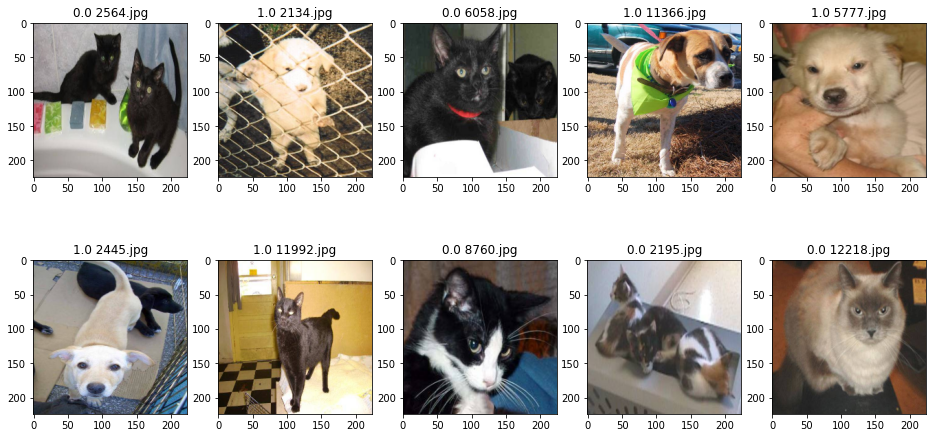

In [45]:
fig = plt.figure(figsize=(16, 8))
for i, (path, score) in enumerate(zip(test_files[:10], test_pred[:10]), 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%.1f %s' % (score, os.path.basename(path)))
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    subplot.imshow(img)

## Готовим данные для отправки

In [43]:
import re

with open('submit.csv', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(test_files, test_pred):
        dst.write('%s,%.1f\n' % (re.search('(\d+).jpg$', path).group(1), score))